In [ ]:
%run preprocessing.ipynb

In [ ]:
file_path  = "model/attn.pth"

In [61]:
%run temporal_preprocess.ipynb

100%|██████████| 6/6 [10:05<00:00, 100.84s/it]


                       Feature  Importance
0                       ged_sb    0.110170
1               decay_ged_ns_1    0.093904
2      sptime_dist_k001_ged_ns    0.056308
3       splag_1_decay_ged_sb_1    0.036163
4      sptime_dist_k001_ged_os    0.035480
5           wdi_nv_agr_totl_kd    0.032562
6       sptime_dist_k10_ged_ns    0.026247
7       sptime_dist_k10_ged_os    0.026067
8        sptime_dist_k1_ged_ns    0.022564
9              spei_48_detrend    0.021945
10           spei1_gsm_detrend    0.018793
11       mov_avg_6_ged_best_sb    0.018090
12  ged_sb_decay_12_time_since    0.017665
13       mov_sum_6_ged_best_sb    0.016402
14                   ged_gte_1    0.015310
15                treelag_1_ns    0.014598
16                treelag_2_os    0.014470
17                treelag_2_ns    0.014419
18                treelag_1_os    0.014219
19             spei1_gs_prev10    0.012776
20       sptime_dist_k1_ged_sb    0.012193
21      sptime_dist_k10_ged_sb    0.012161
22        s

In [62]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [69]:
master_df

,ged_sb,ged_os,ged_ns,ln_pop_gpw_sum,decay_ged_sb_1,decay_ged_sb_25,decay_ged_os_1,decay_ged_sb_5,decay_ged_sb_100,decay_ged_sb_500,...,treelag_2_os,sptime_dist_k1_ged_os,sptime_dist_k1_ged_ns,sptime_dist_k10_ged_os,sptime_dist_k10_ged_ns,sptime_dist_k001_ged_os,sptime_dist_k001_ged_ns,month_id,priogrid_gid,date
0,-0.026241,-0.021117,-0.015904,-4.441878,-0.273763,-0.152357,-0.240096,-0.193102,-0.06916,-0.028508,...,-0.153469,7.579966,6.400377,6.532327,6.738254,9.639623,4.738637,433,62356,2016-01-01
1,-0.026241,-0.021117,-0.015904,-0.299347,-0.273763,-0.152357,-0.240096,-0.193102,-0.06916,-0.028508,...,-0.149642,6.073162,4.577182,4.485963,4.768209,0.392014,-0.475191,433,79599,2016-01-01
2,-0.026241,-0.021117,-0.015904,-0.639355,-0.273763,-0.152357,-0.240096,-0.193102,-0.06916,-0.028508,...,-0.149642,6.039653,4.558453,4.459127,4.792157,0.420701,-0.419315,433,79600,2016-01-01
3,-0.026241,-0.021117,-0.015904,0.044118,-0.273763,-0.152357,-0.240096,-0.193102,-0.06916,-0.028508,...,-0.149642,6.008172,4.540879,4.433556,4.816913,0.504226,-0.333919,433,79601,2016-01-01
4,-0.026241,-0.021117,-0.015904,1.125607,-0.273763,-0.152357,-0.240096,-0.193102,-0.06916,-0.028508,...,-0.149496,6.028812,4.549976,4.457748,4.650759,0.315186,-0.494762,433,80317,2016-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048795,-0.026241,-0.021117,-0.015904,0.272952,-0.273781,-0.152391,-0.240117,-0.193102,-0.06916,-0.028508,...,-0.148353,1.500916,0.405020,1.087421,0.158557,-0.447833,2.320298,502,190496,2021-10-01
1048796,-0.026241,-0.021117,-0.015904,-1.430836,-0.273781,-0.152391,-0.240117,-0.193102,-0.06916,-0.028508,...,-0.148255,0.535759,-0.273830,0.283821,-0.470458,0.284241,0.995333,502,190507,2021-10-01
1048797,-0.026241,-0.021117,-0.015904,-2.375368,-0.273781,-0.152391,-0.240117,-0.193102,-0.06916,-0.028508,...,-0.148247,0.467794,-0.316462,0.220832,-0.512859,0.374058,0.908653,502,190508,2021-10-01
1048798,-0.026241,-0.021117,-0.015904,-0.990413,-0.273781,-0.152391,-0.240117,-0.193102,-0.06916,-0.028508,...,-0.148189,0.350580,-0.385566,0.102800,-0.584801,0.695895,0.767960,502,190510,2021-10-01


In [63]:
print(top_50_features)

['ged_sb', 'decay_ged_ns_1', 'sptime_dist_k001_ged_ns', 'splag_1_decay_ged_sb_1', 'sptime_dist_k001_ged_os', 'wdi_nv_agr_totl_kd', 'sptime_dist_k10_ged_ns', 'sptime_dist_k10_ged_os', 'sptime_dist_k1_ged_ns', 'spei_48_detrend', 'spei1_gsm_detrend', 'mov_avg_6_ged_best_sb', 'ged_sb_decay_12_time_since', 'mov_sum_6_ged_best_sb', 'ged_gte_1', 'treelag_1_ns', 'treelag_2_os', 'treelag_2_ns', 'treelag_1_os', 'spei1_gs_prev10', 'sptime_dist_k1_ged_sb', 'sptime_dist_k10_ged_sb', 'spei1_gs_prev10_anom', 'ged_sb_tlag_1_splag_1', 'tlag1_spei1_gsm', 'mov_avg_12_ged_best_sb', 'sptime_dist_k1_ged_os', 'ged_sb_tlag_1', 'sptime_dist_k001_ged_sb', 'mov_sum_12_ged_best_sb', 'mov_sum_36_ged_best_sb', 'ged_sb_tlag_7', 'spei1gsy_lowermedian_count', 'ged_sb_tlag_2', 'spei1_gsm_cv_anom', 'ged_sb_tlag_3', 'mov_avg_36_ged_best_sb', 'ged_sb_tlag_4', 'decay_ged_sb_25', 'ged_sb_tlag_11', 'ged_sb_tlag_9', 'ged_sb_tlag_12', 'ged_sb_tlag_8', 'treelag_1_sb', 'ged_sb_tlag_5', 'count_moder_drought_prev10', 'ged_sb_tlag_

In [64]:
transformer_input

{-3.086626264365936: array([[-0.02624148506649588, -0.16565360732335718, 4.738637299186637,
         ..., -0.33348748598929434, Timestamp('2016-01-01 00:00:00'),
         -3.086626264365936],
        [-0.02624148506649588, -0.16565360733085963, 4.739244262861304,
         ..., -0.33348748598929434, Timestamp('2016-02-01 00:00:00'),
         -3.086626264365936],
        [-0.02624148506649588, -0.165653607337941, 4.739853113020522, ...,
         -0.33348748598929434, Timestamp('2016-03-01 00:00:00'),
         -3.086626264365936],
        ...,
        [-0.02624148506649588, -0.1656536074542412, 4.783446059925778,
         ..., -0.3334874859892945, Timestamp('2021-08-01 00:00:00'),
         -3.086626264365936],
        [-0.02624148506649588, -0.1656536074543977, 4.784178069206026,
         ..., -0.3334874859892945, Timestamp('2021-09-01 00:00:00'),
         -3.086626264365936],
        [-0.02624148506649588, -0.16565360745454535, 4.7849119229850094,
         ..., -0.3334874859892945, Times

In [65]:
len(transformer_input)

13110

In [66]:
date_encodings

{-3.086626264365936: Index([1451606400.0, 1454284800.0, 1456790400.0, 1459468800.0, 1462060800.0,
        1464739200.0, 1467331200.0, 1470009600.0, 1472688000.0, 1475280000.0,
        1477958400.0, 1480550400.0, 1483228800.0, 1485907200.0, 1488326400.0,
        1491004800.0, 1493596800.0, 1496275200.0, 1498867200.0, 1501545600.0,
        1504224000.0, 1506816000.0, 1509494400.0, 1512086400.0, 1514764800.0,
        1517443200.0, 1519862400.0, 1522540800.0, 1525132800.0, 1527811200.0,
        1530403200.0, 1533081600.0, 1535760000.0, 1538352000.0, 1541030400.0,
        1543622400.0, 1546300800.0, 1548979200.0, 1551398400.0, 1554076800.0,
        1556668800.0, 1559347200.0, 1561939200.0, 1564617600.0, 1567296000.0,
        1569888000.0, 1572566400.0, 1575158400.0, 1577836800.0, 1577836800.0,
        1580515200.0, 1580515200.0, 1583020800.0, 1583020800.0, 1585699200.0,
        1585699200.0, 1588291200.0, 1588291200.0, 1590969600.0, 1590969600.0,
        1593561600.0, 1593561600.0, 15962400

In [67]:
class TransformerDataset(Dataset):
    def __init__(self, data, date_encodings):
        self.data = data
        self.date_encodings = date_encodings

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        gid = list(self.data.keys())[idx]
        features = np.array(self.data[gid][:, :-2], dtype=np.float32)
        target = np.array(self.data[gid][:, -1], dtype=np.float32)
        dates = self.date_encodings[gid]
        return torch.tensor(features), torch.tensor(dates), torch.tensor(target)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x, dates):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TemporalTransformerEncoder(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dim_feedforward=512, dropout=0.1):
        super(TemporalTransformerEncoder, self).__init__()
        self.input_embedding = nn.Linear(input_size, d_model // 2)
        self.pos_encoder = PositionalEncoding(d_model // 2, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model // 2, nhead=nhead // 2, dim_feedforward=dim_feedforward // 2, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model // 2, 1)

    def forward(self, x, dates):
        x = self.input_embedding(x)
        x = self.pos_encoder(x, dates)
        x = self.transformer_encoder(x)
        output = self.output_layer(x)
        return output.squeeze(-1)

In [68]:
dataset = TransformerDataset(transformer_input, date_encodings)
train_set, val_set = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader([dataset[i] for i in train_set], batch_size=64, shuffle=True)
val_loader = DataLoader([dataset[i] for i in val_set], batch_size=64, shuffle=False)
model = TemporalTransformerEncoder(input_size=len(top_50_features), d_model=12, nhead=4, num_layers=16)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def r_squared(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return r2.item()

train_losses = []
val_losses = []
val_r2_scores = []
for epoch in range(10):
    model.train()
    train_loss = 0
    for x, dates, target in train_loader:
        optimizer.zero_grad()
        output = model(x, dates)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0
    total_r2 = 0
    with torch.no_grad():
        for x, dates, target in val_loader:
            output = model(x, dates)
            loss = criterion(output, target)
            val_loss += loss.item()
            total_r2 += r_squared(target, output)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    avg_r2 = total_r2 / len(val_loader)
    val_r2_scores.append(avg_r2)
    if train_loss <= 0.4:
        print(f"Early Stoping at Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val R^2: {avg_r2:.4f}") 
        torch.save(model.state_dict(), file_path)
        print(f"Model saved at {file_path}")
        break
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val R^2: {avg_r2:.4f}')

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch: 1, Training Loss: 0.8644, Val Loss: 0.5937, Val R^2: 0.4109
Epoch: 2, Training Loss: 0.6457, Val Loss: 0.4413, Val R^2: 0.5608


KeyboardInterrupt: 

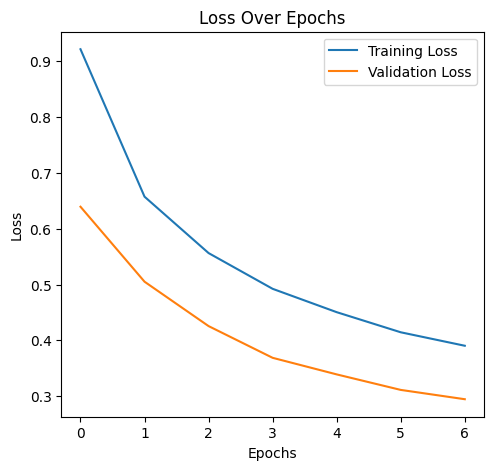

In [31]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

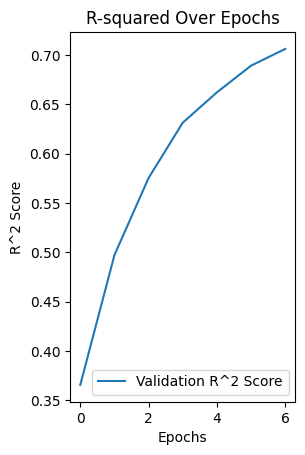

In [32]:
# Plotting R-squared values
plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label='Validation R^2 Score')
plt.title('R-squared Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()